# Датасет [WIDER FACES](http://shuoyang1213.me/WIDERFACE/)


In [1]:
from scipy import io
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import os

In [2]:
path_mat = 'WiderFaces/wider_face_train.mat'
path_images = 'C:/Users/Fedor/Documents/Projects/BelkaFaces/WiredFaces/WIDER_train/All'

In [3]:
mat = io.loadmat(path_mat)

### Список всех файлов

In [4]:
all_files = mat['file_list']

### Список всех координат лиц

In [5]:
all_boxes = mat['face_bbx_list']

## Пример изображений в датасете

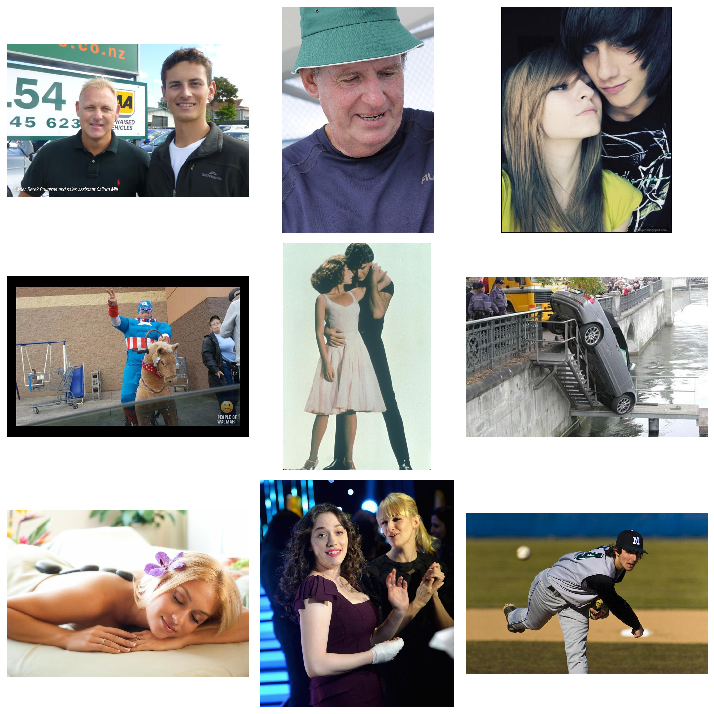

In [525]:
display_images(choose_random_images())

## Получим данные об изображениях в датасете

### Выберем рандомное изображение

In [325]:
random_image = choose_random_images(n=1)[0]
random_image

'40_Gymnastics_Gymnastics_40_578.jpg'

### Его номер в датасете 

In [326]:
folder, file = get_num_of_image(random_image)

Folder: 35 
File: 60


### Координаты лиц на изображении

In [327]:
boxes = get_boxes(folder, file)
boxes

array([[ 55, 214,  39,  38],
       [140, 251,  35,  40],
       [228, 274,  36,  40],
       [257, 237,  35,  38],
       [241, 192,  36,  42],
       [325, 278,  36,  42],
       [349, 222,  36,  38],
       [422, 281,  38,  43],
       [450, 232,  38,  45],
       [569, 221,  48,  48],
       [538, 285,  38,  48],
       [646, 290,  40,  45],
       [753, 153,  41,  48],
       [697, 222,  39,  49],
       [864, 166,  46,  54],
       [762, 297,  38,  43],
       [885, 310,  40,  48]])

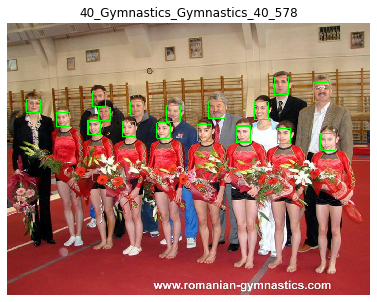

In [328]:
draw_rect(random_image, boxes)

## Easy (Scale) WIDER FACES

Датасет делится на три уровня сложности по размеру лиц на изображении: Легкий (больше 300 pixels), Средний (50-300 pixels), Сложный (10-50 pixels). Мы будем рассматривать легкую часть датасета (по рамзеру лиц), т.к. нам больше важен аспект расположения лица (угол, наклон) и аспект occlusion (макияж, маски, очки и т.д.). К тому же нет необходимости обнаруживать совсем маленькие лица на изображениях. 

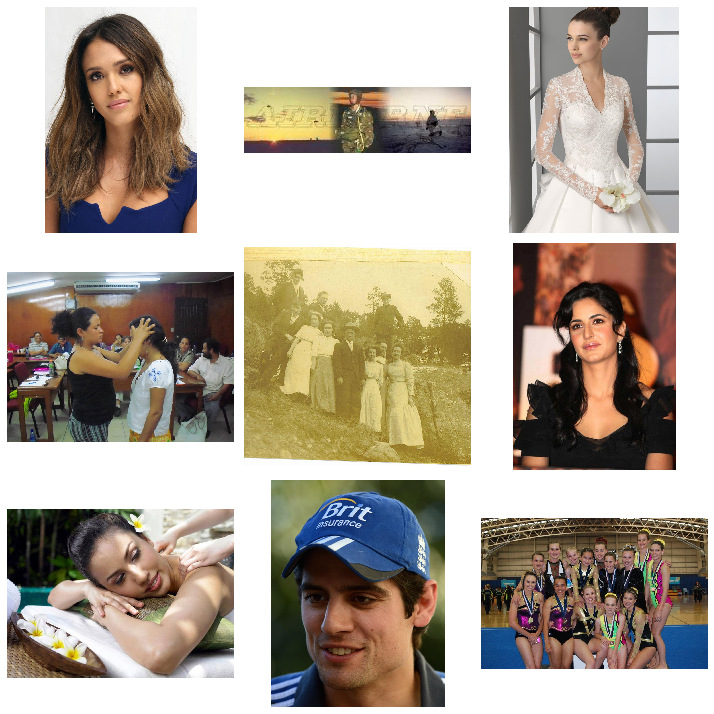

In [19]:
display_images(choose_random_images(easy=True))

# Тестирование решений

**Как будем тестировать?** 

1. Выбираем рандомные n изображений из датасета
2. Получаем координаты всех лиц на всех изображениях 
3. Получаем результаты работы методов на этих изображениях, т.е. получаем координаты лиц
4. Сравниваем полученные результаты с реальными координатами 
5. Считаем TP, FP, FN и recall
6. Сортируем по возрастанию recall

### N рандомных изображений

In [54]:
N = 3
images = choose_random_images(easy=True, n=N)

### Координаты лиц

In [55]:
boxes = get_all_boxes(images)

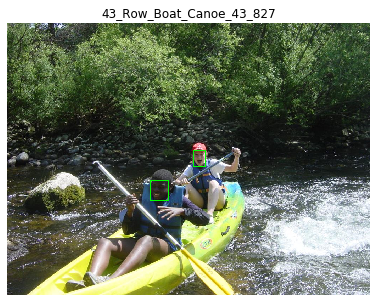

In [60]:
r = random.choice(range(0, N))
draw_rect(images[r], boxes[r])

### Точность метода
Для определения точности работы алгоритма будем использовать метрику IOU (Intersection over Union). Для каждого лица на изображении (ground-truth вектор) проверяем среди всех полученных векторов из метода параметр IOU. Если этот параметр $\geq0.5$, то лицо обнаружено верно, этот вектор обозначим как True Positive (TP). Если в конце у нас остались неподходящие векторы, то обозначаем как False Positive (FP). Если же лица вовсе не обнаружены, то обозначаем их как False Negative (FN). Из всевозможных метрик нам наиболее важен **recall, precision, F-score** (**recall** показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм, т.е. показывает сколько лиц из всех лиц мы действительно нашли; **precision** -- точность; **F-score** -- среднее гармоническое precision и recall).

## Каскады Хаара и LBP ([OpenCV](https://github.com/opencv/opencv))

### Каскады Хаара

In [52]:
haar_path = 'HaarCascades/'
haars = [haar_path + x for x in os.listdir(haar_path)]
haars

['HaarCascades/haarcascade_frontalface_alt.xml',
 'HaarCascades/haarcascade_frontalface_alt2.xml',
 'HaarCascades/haarcascade_frontalface_alt_tree.xml',
 'HaarCascades/haarcascade_frontalface_default.xml',
 'HaarCascades/haarcascade_profileface.xml']

#### Результаты разных каскадов Хаара

In [113]:
haar_res = cascades_results(haars)
haar_res

{'haarcascade_frontalface_alt': {'TP': 16,
  'FN': 23,
  'FP': 0,
  'Recall': 0.41025641025641024,
  'Precision': 1.0,
  'F-score': 0.5818181818181819},
 'haarcascade_frontalface_alt2': {'TP': 17,
  'FN': 22,
  'FP': 1,
  'Recall': 0.4358974358974359,
  'Precision': 0.9444444444444444,
  'F-score': 0.5964912280701755},
 'haarcascade_frontalface_alt_tree': {'TP': 2,
  'FN': 37,
  'FP': 0,
  'Recall': 0.05128205128205128,
  'Precision': 1.0,
  'F-score': 0.09756097560975609},
 'haarcascade_frontalface_default': {'TP': 13,
  'FN': 26,
  'FP': 2,
  'Recall': 0.3333333333333333,
  'Precision': 0.8666666666666667,
  'F-score': 0.48148148148148145},
 'haarcascade_profileface': {'TP': 3,
  'FN': 36,
  'FP': 2,
  'Recall': 0.07692307692307693,
  'Precision': 0.6,
  'F-score': 0.13636363636363635}}

#### Лучший результат

In [114]:
best_haar = get_best_cascade(haar_res)

 Cascade: haarcascade_frontalface_alt2 
 TP: 17 
 FN: 22 
 FP: 1 
 Recall: 0.4358974358974359 Precision: 0.9444444444444444 
 F-score: 0.5964912280701755


### Каскады LBP

In [72]:
lbp_path = 'LBPCascades/'
lbps = [lbp_path + x for x in os.listdir(lbp_path)]
lbps

['LBPCascades/lbpcascade_frontalface.xml',
 'LBPCascades/lbpcascade_frontalface_improved.xml',
 'LBPCascades/lbpcascade_profileface.xml']

#### Результаты разных LBP каскадов

In [96]:
lbp_res = cascades_results(lbps)
lbp_res

{'lbpcascade_frontalface': {'TP': 6,
  'FN': 19,
  'FP': 0,
  'Recall': 0.24,
  'Precision': 1.0,
  'F-score': 0.3870967741935484},
 'lbpcascade_frontalface_improved': {'TP': 1,
  'FN': 24,
  'FP': 1,
  'Recall': 0.04,
  'Precision': 0.5,
  'F-score': 0.07407407407407407},
 'lbpcascade_profileface': {'TP': 0,
  'FN': 25,
  'FP': 0,
  'Recall': 0.0,
  'Precision': None,
  'F-score': None}}

#### Лучший результат

In [97]:
best_lbp = get_best_cascade(lbp_res)

 Cascade: lbpcascade_frontalface 
 TP: 6 
 FN: 19 
 FP: 0 
 Recall: 0.24 Precision: 1.0 
 F-score: 0.3870967741935484


## [FaceNet’s MTCNN](https://github.com/davidsandberg/facenet/tree/master/src/align)

In [67]:
from mtcnn import MTCNN 

Using TensorFlow backend.


In [68]:
mtcnn_boxes = mtcnn_faces(images)

In [69]:
best_mtcnn = show_result(mtcnn_boxes, boxes, "MTCNN") 

 MTCNN 
 TP: 1 
 FN: 4 
 FP: 0 
 Recall: 0.2 
 Precision: 1.0 
 F-score: 0.33333333333333337


## [dlib's HOG](http://dlib.net/)

In [111]:
import dlib 

In [118]:
hog_boxes = hog_faces(images)

In [119]:
best_hog = show_result(hog_boxes, boxes, "HOG")

 HOG 
 TP: 5 
 FN: 34 
 FP: 0 
 Recall: 0.1282051282051282 
 Precision: 1.0 
 F-score: 0.22727272727272727


## [dlib's MMOD](http://dlib.net/)

In [460]:
import dlib 

In [481]:
mmod_boxes = mmod_faces(images)

In [486]:
best_hog = show_result(mmod_boxes, boxes, "MMOD")

 MMOD 
 TP: 2 
 FN: 1 
 FP: 0 
 Recall: 0.6666666666666666


## [Single-Shot-Multibox detector](https://arxiv.org/abs/1512.02325)

In [70]:
modelFile = "models/opencv_face_detector_uint8.pb"
configFile = "models/opencv_face_detector.pbtxt"
net = cv2.dnn.readNetFromTensorflow(modelFile, configFile)

In [71]:
ssd_boxes = ssd_faces(images)

In [72]:
best_ssd = show_result(ssd_boxes, boxes, "SSD") 

 SSD 
 TP: 3 
 FN: 2 
 FP: 5 
 Recall: 0.6 
 Precision: 0.375 
 F-score: 0.4615384615384615


## Тест на угол
Посмотрим как работают методы на лица под углом. Нарисуем прямоугольники и сделаем gif-файлы.

In [74]:
frames_path = "Test\AngleTest\Frames"
frames = sort_frames(frames_path)

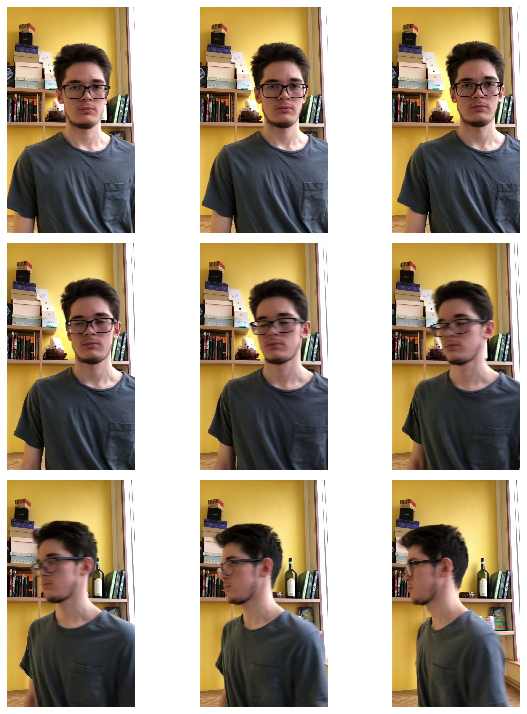

In [76]:
display_images(frames, frames_path)

In [135]:
def test_angle(method, frames, frames_path=frames_path):
    count = 0
    for frame in frames:
        test_image = cv2.imread(frames_path + "\\" + frame)
        img_copy = np.copy(test_image)
        boxes = method([frame], frames_path)
        for (x, y, w, h) in boxes[0]:
            cv2.rectangle(img_copy,(x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.imwrite("Test\\" + method.__name__ + "\\img_" + str(count) + ".jpg", img_copy)
        count += 1

In [134]:
test_angle(hog_faces, frames)

# Helpers

## Common

In [73]:
def sort_frames(frames_path):
    frames = os.listdir(frames_path)
    frames_new = []
    for i in range(0, 189):
        for frame in frames:
            if(str(i) == frame.split("frame")[1].split(".")[0]):
                frames_new.append(frame)

    return frames_new 

In [6]:
easy_names = ['Gymnastics', 'Handshaking', 'Waiter', 'Conference',
                'Worker', 'Parachutist', 'Coach', 'Meeting',
                'Aerobics', 'Boat', 'Dancing', 'Swimming', 
                'Family', 'Balloonist', 'Dresses', 'Couple', 
                'Jockey', 'Tennis', 'Spa', 'Surgeons']


In [7]:
def convert2RGB(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [8]:
def choose_random_images(easy=False, n=10):
    
    """
    Выбрать из датасета n картинок в случайном порядке
    easy=True -- выбрать из легкой части датасета  
    """
    
    images = []
    for _ in range(n):
        if(easy):
            easy_folders = get_easy_folders()
            folder = all_files[random.choice(easy_folders)]
        else:    
            folder = random.choice(all_files)
            
        name = random.choice(folder[0])[0][0]
        images.append(name + ".jpg")
    return images

In [9]:
def get_num_of_image(name):
    folder_num = -1 
    file_num = -1
    for folder in all_files:
        folder_num += 1
        file_num = -1
        for file_name in folder[0]:
            file_num += 1
            name_ = file_name[0][0]
            if (name_ + '.jpg' == name):
                # print("Folder: {0} \nFile: {1}".format(folder_num, file_num))
                return folder_num, file_num    

In [10]:
def get_boxes(folder, file):
    return all_boxes[folder][0][file][0]

In [11]:
def get_all_boxes(images):
    boxes = []
    for image in images:
        folder, file = get_num_of_image(image)
        boxes.append(get_boxes(folder, file))
    return boxes

In [12]:
def draw_rect(image, boxes):
    test_image = cv2.imread(path_images + '//' + image)
    img_copy = np.copy(test_image)
    
    for (x, y, w, h) in boxes:
        cv2.rectangle(img_copy,(x, y), (x+w, y+h), (0, 255, 0), 2)
        
    fig,ax = plt.subplots(1)
    fig.set_size_inches(9, 5)
    ax.set_title(image.split('.')[0])
    ax.imshow(convert2RGB(img_copy))
    plt.axis('off')
    plt.show()

In [13]:
def display_images(images, path_images=path_images):
    fig=plt.figure(figsize=(10, 10))
    columns = 3
    rows = 3
    for i in range(1, columns*rows +1):
        test_image = cv2.imread(path_images + '//' + images[i])
        img_copy = np.copy(test_image)
        
        fig.add_subplot(rows, columns, i)
        plt.imshow(convert2RGB(img_copy))
        plt.axis('off')
        plt.tight_layout(True)
    plt.show()

In [14]:
def get_easy_folders(easy_names=easy_names):
    easy_folders = []
    for name in easy_names:
        for i in range(0, len(all_files)):
            if (name in all_files[i][0][0][0][0]):
                easy_folders.append(i)
    return easy_folders

## Metrics

In [15]:
def bb_intersection_over_union(ground_truth, predicted):
    
    boxA = [ground_truth[0], ground_truth[1], ground_truth[0] +
            ground_truth[2], ground_truth[1] + ground_truth[3]]
    boxB = [predicted[0], predicted[1], predicted[0] +
                 predicted[2], predicted[1] + predicted[3]]
    
    # (x, y) - координаты прямоугольника из пересечения
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    # Площадь прямоугольника, образованного пересечением двух других
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    
    # Общая площадь двух прямоугольников
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    # intersection over union 
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    return iou

In [16]:
def calculate_metrics(results, boxes, beta=1):
    
    TP = 0 # true-positive
    FP = 0 # false-positive 
    FN = 0 # false-negative
    
    # Бежим по всем ground-truth группам лиц
    for i in range(0, len(boxes)):
        tp = 0
        fp = 0
        fn = 0
        # Бежим по всем ground-truth лицам на изображении
        for j in range(0,len(boxes[i])):
            # Сравниваем с нашими результатами
            for box in results[i]:
                if (bb_intersection_over_union(boxes[i][j], box) >= 0.5):
                    tp += 1
            fp = len(results[i]) - tp
            fn = len(boxes[i]) - tp
            
        TP += tp
        FP += fp
        FN += fn
    
    recall_ = recall(TP, FN)
    precision_ = precision(TP, FP)
    f_score_ = f_score(recall_, precision_, beta)
    
    return (TP, FN, FP), recall_, precision_, f_score_

In [17]:
def recall(TP, FN):
    if (TP + FN != 0):
        return TP/(TP + FN)
    else: 
        return None

In [18]:
def precision(TP, FP):
    if (TP + FP != 0):
        return TP/(TP + FP)
    else:
        return None

In [19]:
def f_score(recall, precision, beta):
    if (recall != None and precision != None):
        return (1 + beta**2) * (precision * recall)/((beta**2 * precision) + recall)
    else:
        return None

In [20]:
def show_result(results, boxes, name):
    res = {}
    metrics = {}
    (TP, FN, FP), recall, precision, f_score = calculate_metrics(results, boxes)
    metrics["TP"] = TP
    metrics["FN"] = FN
    metrics["FP"] = FP
    metrics["Recall"] = recall
    metrics["Precision"] = precision
    metrics["F-score"] = f_score
    res[name] = metrics

    print(" {4} \n TP: {0} \n FN: {1} \n FP: {2} \n Recall: {3} \n Precision: {5} \n F-score: {6}".format(metrics["TP"],
                                                                                                          metrics["FN"], metrics["FP"],
                                                                                                          metrics["Recall"], name, 
                                                                                                          metrics["Precision"],
                                                                                                          metrics["F-score"]))
    return res

## Detections

In [118]:
def cascades_faces(cascade_path, images, path_images=path_images):
    
    def cascades_faces_detect(cascade_path, colored_img, scaleFactor=1.1):

        cascade = cv2.CascadeClassifier(cascade_path)
        img_copy = np.copy(colored_img)
        gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
        faces = cascade.detectMultiScale(
            gray, scaleFactor=scaleFactor, minNeighbors=5)
        return faces
    
    all_faces = []
    for image in images:
        faces = cascades_faces_detect(cascade_path, cv2.imread(path_images + '/' + image))
        all_faces.append(faces)
        
    return all_faces

In [22]:
def cascades_results(cascades):
    res = {}
    for cascade in cascades:
        metrics = {}
        results_cascade = cascades_faces(cascade, images)
        (TP, FN, FP), recall, precision, f_score = calculate_metrics(results_cascade, boxes)
        metrics["TP"] = TP
        metrics["FN"] = FN
        metrics["FP"] = FP
        metrics["Recall"] = recall
        metrics["Precision"] = precision
        metrics["F-score"] = f_score
        name = cascade.split('/')[1].split('.')[0]
        res[name] = metrics
    return res

In [23]:
def get_best_cascade(d):
    sorted_d = sorted(d.items(), key=lambda item: list(item[1].items())[3][1])
    best = sorted_d[-1:][0]

    print(" Cascade: {0} \n TP: {1} \n FN: {2} \n FP: {3} \n Recall: {4} Precision: {5} \n F-score: {6}".format(best[0],
                                                                                                                best[1]["TP"],
                                                                                                                best[1]["FN"], 
                                                                                                                best[1]["FP"],
                                                                                                                best[1]["Recall"],
                                                                                                               best[1]["Precision"],
                                                                                                               best[1]["F-score"]))
    return sorted_d[-1:][0]

In [63]:
def mtcnn_faces(images, path_images=path_images):
    
    def mtcnn_faces_detect(img):
        detector = MTCNN()
        image = cv2.imread(path_images + '/' + img)
        faces = detector.detect_faces(image)    
        return faces 
    
    all_faces = []
    for image in images:
        faces = mtcnn_faces_detect(image)
        tmp = []
        for face in faces:
            tmp.append(face["box"])
        all_faces.append(tmp)
        
    return all_faces

In [113]:
def hog_faces(images, path_images=path_images):
    
    all_faces = []
    for image in images:
        boxes = []
        frame = cv2.imread(path_images + "//" + image)
        hogFaceDetector = dlib.get_frontal_face_detector()
        faceRects = hogFaceDetector(frame, 0)
        for faceRect in faceRects:
            x1 = faceRect.left()
            y1 = faceRect.top()
            x2 = faceRect.right() - x1
            y2 = faceRect.bottom() - y1
            boxes.append([x1, y1, x2, y2])
        all_faces.append(boxes)
        
    return all_faces 

In [65]:
def mmod_faces(images, path_images=path_images):
    
    all_faces = []
    for image in images:
        boxes = []
        frame = cv2.imread(path_images + "//" + image)
        dnnFaceDetector = dlib.cnn_face_detection_model_v1("models/mmod_human_face_detector.dat")
        faceRects = dnnFaceDetector(frame, 0)
        for faceRect in faceRects:
            x1 = faceRect.rect.left()
            y1 = faceRect.rect.top()
            x2 = faceRect.rect.right() - x1
            y2 = faceRect.rect.bottom() - y1
            boxes.append([x1, y1, x2, y2])
        all_faces.append(boxes)
    
    return all_faces

In [106]:
def ssd_faces(images, path_images=path_images, acc=0.40):
    
    all_faces = []
    for image in images:
        
        frame = cv2.imread(path_images + "//" + image)
        blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), [104, 117, 123], False, False)

        net.setInput(blob)
        detections = net.forward()
        bboxes = []
        frameHeight = frame.shape[0]
        frameWidth = frame.shape[1]
        for i in range(detections.shape[2]):
            confidence = detections[0, 0, i, 2]
            if confidence > acc:
                x1 = int(detections[0, 0, i, 3] * frameWidth)
                y1 = int(detections[0, 0, i, 4] * frameHeight)
                x2 = int(detections[0, 0, i, 5] * frameWidth) - x1
                y2 = int(detections[0, 0, i, 6] * frameHeight) - y1
                bboxes.append([x1, y1, x2, y2])
        all_faces.append(bboxes)
        
    return all_faces